# 1. Importando as bibliotecas

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances, silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator
import requests
import zipfile
import io

# 2. Baixando e carregando os dados

URL dos dados

In [2]:
data_url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"

Baixar e extrair o arquivo zip

In [3]:
response = requests.get(data_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall("ml-1m")

Carregar os dados

In [4]:
ratings = pd.read_csv('ml-1m/ml-1m/ratings.dat', sep='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')

In [5]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movies = pd.read_csv('ml-1m/ml-1m/movies.dat', sep='::', header=None, names=['movie_id', 'title', 'genres'], engine='python', encoding='latin1')

In [7]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies['genres'] = movies['genres'].str.replace('|', ',')
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),"Animation,Children's,Comedy"
1,2,Jumanji (1995),"Adventure,Children's,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama"
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
users = pd.read_csv('ml-1m/ml-1m/users.dat', sep='::', header=None, names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], engine='python')

In [10]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# 3. Análise exploratória dos dados

Valores nulos

In [11]:
movies.isnull().sum()

movie_id    0
title       0
genres      0
dtype: int64

In [12]:
ratings.isnull().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [13]:
users.isnull().sum()

user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

Informações básicas

In [14]:
print(f'Total de avaliações: {ratings.shape[0]}')
print(f'Total de filmes cadastrados: {movies.shape[0]}')
print(f'Total de usuários: {users.shape[0]}')
print(f'Número de usuários que fizeram alguma avaliação: {ratings["user_id"].nunique()}')
print(f'Número de filmes que receberam alguma avaliação: {ratings["movie_id"].nunique()}')

Total de avaliações: 1000209
Total de filmes cadastrados: 3883
Total de usuários: 6040
Número de usuários que fizeram alguma avaliação: 6040
Número de filmes que receberam alguma avaliação: 3706


Quais filmes foram avaliados?

In [15]:
movies_reviewed = movies[movies['movie_id'].isin(ratings['movie_id'])].copy()
movies_reviewed

,movie_id,title,genres
0,1,Toy Story (1995),"Animation,Children's,Comedy"
1,2,Jumanji (1995),"Adventure,Children's,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [16]:
movies_reviewed['movie_id_true'] = range(1, len(movies_reviewed)+1)
movies_reviewed

,movie_id,title,genres,movie_id_true
0,1,Toy Story (1995),"Animation,Children's,Comedy",1
1,2,Jumanji (1995),"Adventure,Children's,Fantasy",2
2,3,Grumpier Old Men (1995),"Comedy,Romance",3
3,4,Waiting to Exhale (1995),"Comedy,Drama",4
4,5,Father of the Bride Part II (1995),Comedy,5
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,3702
3879,3949,Requiem for a Dream (2000),Drama,3703
3880,3950,Tigerland (2000),Drama,3704
3881,3951,Two Family House (2000),Drama,3705


In [17]:
ratings = ratings.merge(movies_reviewed[['movie_id', 'movie_id_true']], on='movie_id', how='left')
ratings

,user_id,movie_id,rating,timestamp,movie_id_true
0,1,1193,5,978300760,1105
1,1,661,3,978302109,640
2,1,914,3,978301968,854
3,1,3408,4,978300275,3178
4,1,2355,5,978824291,2163
...,...,...,...,...,...
1000204,6040,1091,1,956716541,1020
1000205,6040,1094,5,956704887,1023
1000206,6040,562,5,956704746,549
1000207,6040,1096,4,956715648,1025


In [18]:
num_movies = movies_reviewed['movie_id_true'].nunique()
num_movies

3706

Distribuição das avaliações

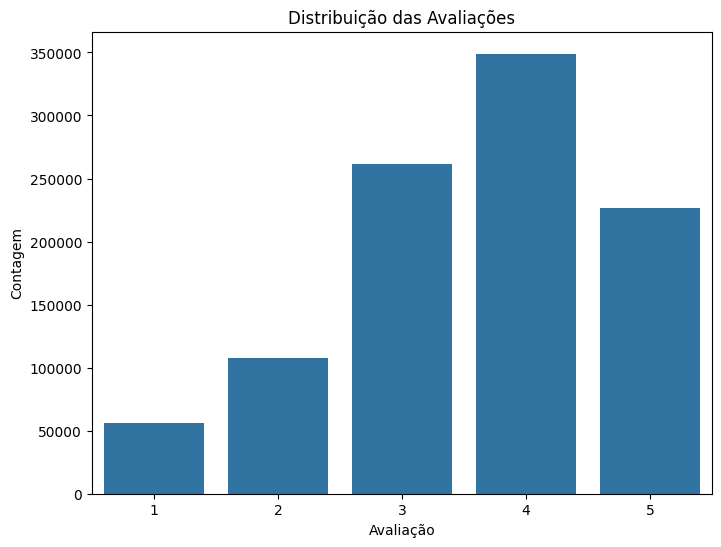

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.show()

Distribuição dos gêneros

C:\Users\wpett\AppData\Local\Temp\ipykernel_22716\3043812017.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h', palette='viridis')


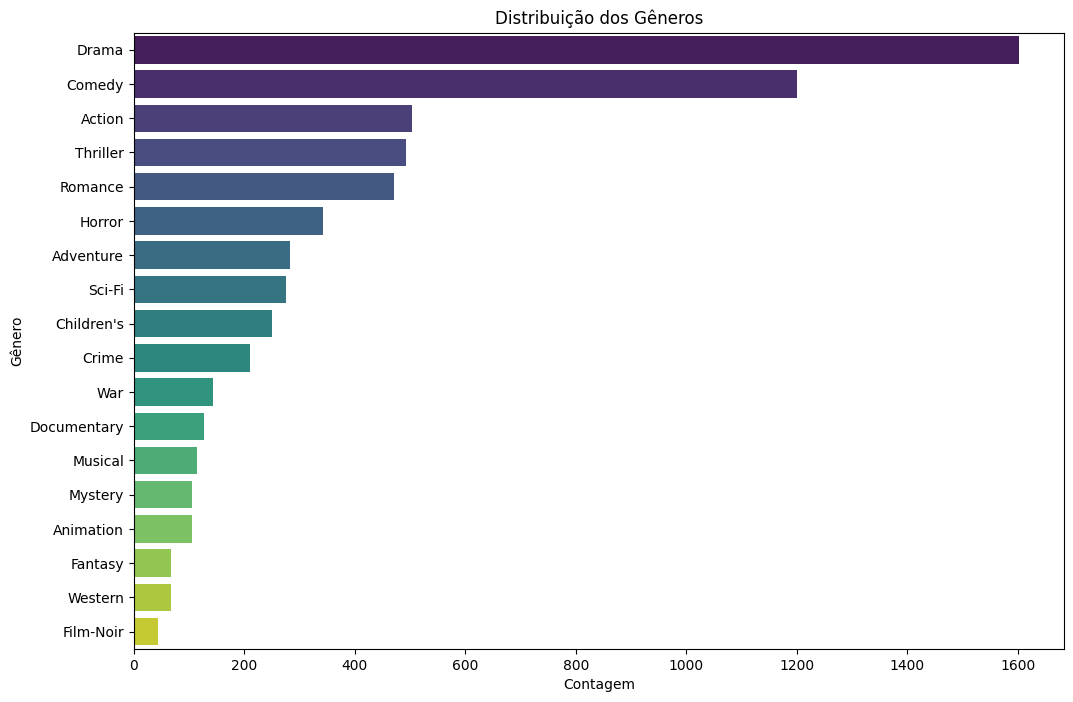

In [20]:
genres = movies['genres'].str.split(',').explode()
genres_list = genres.unique()
genre_counts = genres.value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index, orient='h', palette='viridis')
plt.title('Distribuição dos Gêneros')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.show()

Quantidade de filmes por ano

C:\Users\wpett\AppData\Local\Temp\ipykernel_22716\4137072900.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movies_years_count.index, y=movies_years_count.values, palette="viridis")


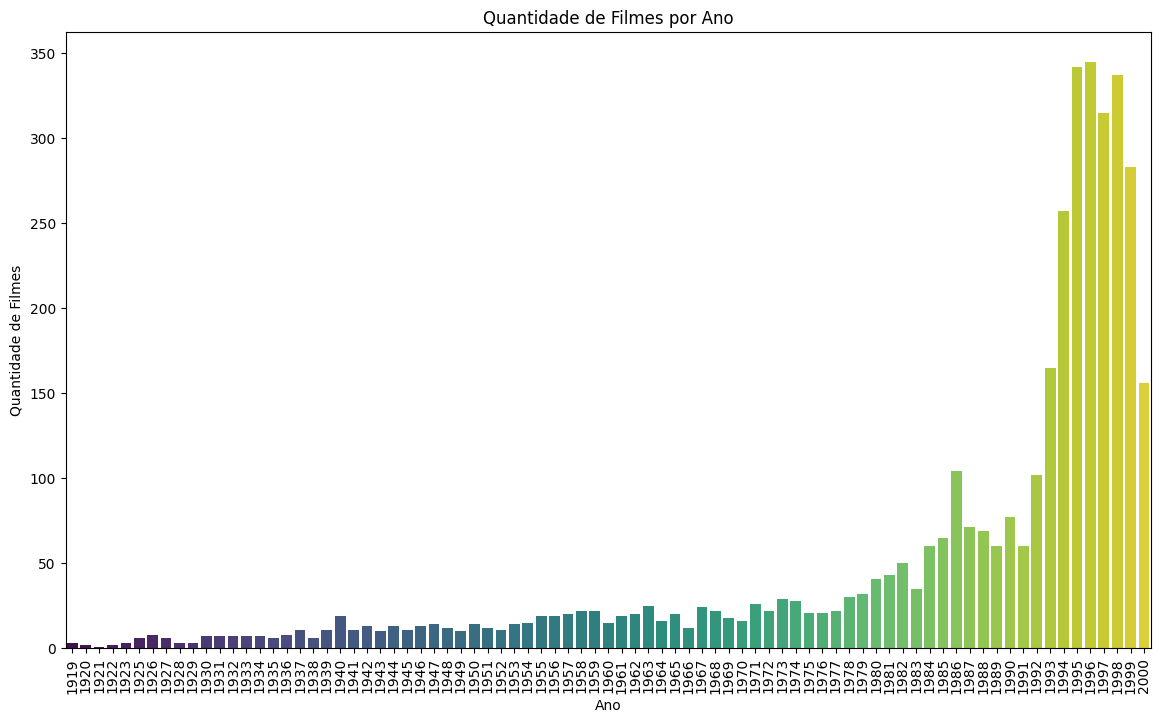

In [21]:
# Extrair o ano de lançamento do título do filme
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Verificar a distribuição dos anos
movies['year'] = movies['year'].astype(int)
movies_years_count = movies['year'].value_counts().sort_index()

# Plotar a quantidade de filmes por ano
plt.figure(figsize=(14, 8))
sns.barplot(x=movies_years_count.index, y=movies_years_count.values, palette="viridis")
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=90)
plt.show()

# 4. Pré-processamento dos dados

Algum usuário avaliou algum filme mais de uma vez?

In [22]:
duplicated_ratings = ratings.duplicated(subset=['user_id', 'movie_id'])
num_duplicated_ratings = duplicated_ratings.sum()
print(f'Número de vezes que um usuário avaliou um filme mais de uma vez: {num_duplicated_ratings}')

Número de vezes que um usuário avaliou um filme mais de uma vez: 0


Há algum filme duplicado?

In [23]:
duplicated_movies = movies.duplicated()
num_duplicated_movies = duplicated_movies.sum()
print(f'Filmes duplicados: {num_duplicated_movies}')

Filmes duplicados: 0


Criando a matriz de classificação, onde as linhas são os filmes e as colunas são as avaliações

In [24]:
ratings_matrix = np.empty((movies_reviewed.shape[0], users.shape[0]))
ratings_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
ratings_matrix[:] = np.nan
ratings_matrix

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [26]:
for index, row in ratings.iterrows():
    ratings_matrix[row['movie_id_true']-1][row['user_id']-1] = row['rating']

ratings_matrix

array([[ 5., nan, nan, ..., nan, nan,  3.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [27]:
ratings_matrix.shape

(3706, 6040)

In [28]:
def replace_nans_with_row_mean(matrix):
    for i in range(matrix.shape[0]):
        row = matrix[i, :]
        mean_value = np.nanmean(row)
        row[np.isnan(row)] = mean_value
    return matrix

In [29]:
ratings_matrix = replace_nans_with_row_mean(ratings_matrix)
ratings_matrix

array([[5.        , 4.14684641, 4.14684641, ..., 4.14684641, 4.14684641,
        3.        ],
       [3.20114123, 3.20114123, 3.20114123, ..., 3.20114123, 3.20114123,
        3.20114123],
       [3.0167364 , 3.0167364 , 3.0167364 , ..., 3.0167364 , 3.0167364 ,
        3.0167364 ],
       ...,
       [3.66666667, 3.66666667, 3.66666667, ..., 3.66666667, 3.66666667,
        3.66666667],
       [3.9       , 3.9       , 3.9       , ..., 3.9       , 3.9       ,
        3.9       ],
       [3.78092784, 3.78092784, 3.78092784, ..., 3.78092784, 3.78092784,
        3.78092784]])

Aparentemente, alguns filmes tiveram a mesma nota para todos os usuários, fazendo com que o desvio padrão seja 0. Por isso, irei atribuir um valor nulo nesses casos.

In [30]:
def normalize_row(row):
    mean = np.mean(row)
    std = np.std(row)
    mean = np.nanmean(row)
    std = np.nanstd(row)
    if std == 0:
        return np.zeros_like(row)  # Substituir por zeros se o desvio padrão for zero
    return (row - mean) / std
    return (row - mean) / std

In [31]:
ratings_matrix_normalized = np.apply_along_axis(normalize_row, 1, ratings_matrix)
ratings_matrix_normalized

array([[ 1.70731838e+00,  1.77740956e-15,  1.77740956e-15, ...,
         1.77740956e-15,  1.77740956e-15, -2.29505214e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.53184131e-15,  4.53184131e-15,  4.53184131e-15, ...,
         4.53184131e-15,  4.53184131e-15,  4.53184131e-15],
       [ 5.22691510e-15,  5.22691510e-15,  5.22691510e-15, ...,
         5.22691510e-15,  5.22691510e-15,  5.22691510e-15],
       [ 5.62870295e-15,  5.62870295e-15,  5.62870295e-15, ...,
         5.62870295e-15,  5.62870295e-15,  5.62870295e-15]])

In [32]:
total_nans = np.isnan(ratings_matrix_normalized).sum()
print(f"Número total de NaNs: {total_nans}")

Número total de NaNs: 0


# 5. Cálculo das Matrizes de Distâncias

Criando a matriz de distância

In [33]:
dist_matrix = pdist(ratings_matrix_normalized, metric='euclidean')

Fazendo a matriz de distância filme-filme

In [34]:
square_dist_matrix = squareform(dist_matrix)

In [35]:
square_dist_matrix

array([[  0.        , 105.69494673, 107.3649446 , ..., 109.17594079,
        109.26922304, 108.33532832],
       [105.69494673,   0.        , 107.94088516, ..., 110.57554306,
        110.26061826, 109.60542063],
       [107.3649446 , 107.94088516,   0.        , ..., 108.46084939,
        108.92857814, 109.09574796],
       ...,
       [109.17594079, 110.57554306, 108.46084939, ...,   0.        ,
        107.70125075, 106.18090639],
       [109.26922304, 110.26061826, 108.92857814, ..., 107.70125075,
          0.        , 103.6646929 ],
       [108.33532832, 109.60542063, 109.09574796, ..., 106.18090639,
        103.6646929 ,   0.        ]])

# 6. Aplicações dos algoritmos de clusterização

## 6.1. K-Means

Vamos utilizar como base a teoria apresentada no livro "Mãos à Obra: Aprendizado de Máquina com Scikit-Learn, Keras & Tensorflow" do autor Aurélien Géron, 2a ed. 

O autor menciona que, quando não temos nenhuma ideia de qual o número de clusters que devemos utilizar, um bom caminho é plotarmos o gráfico da inércia em função do número de clusters e buscarmos o ponto de inflexão chamado "cotovelo". Vamos primeiro definir os argumentos que serão comuns e plotaremos o gráfico com o número de clusters variando de 2 até 100

In [36]:
kmeans_kwargs = {
    'init': 'random',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
}

In [46]:
inertias = []
silhouette_avg_scores = []
for k in range(2, 100):
    clusterer = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = clusterer.fit_predict(ratings_matrix_normalized)
    inertias.append(clusterer.inertia_)
    silhouette_avg_scores.append(silhouette_score(ratings_matrix_normalized, cluster_labels))
    print(k)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


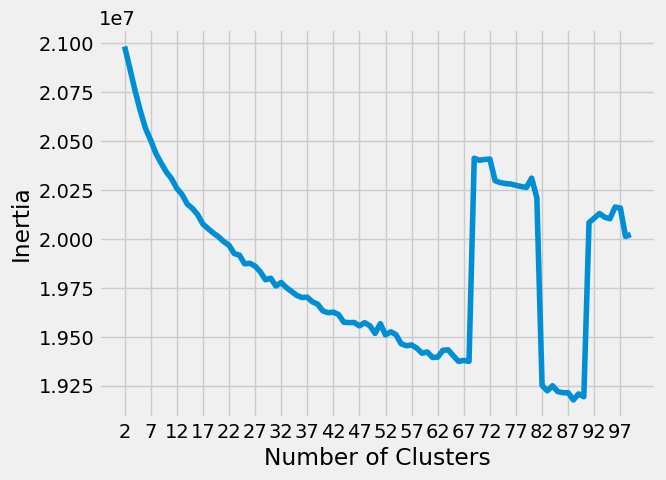

In [47]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 100), inertias)
plt.xticks(range(2, 100, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

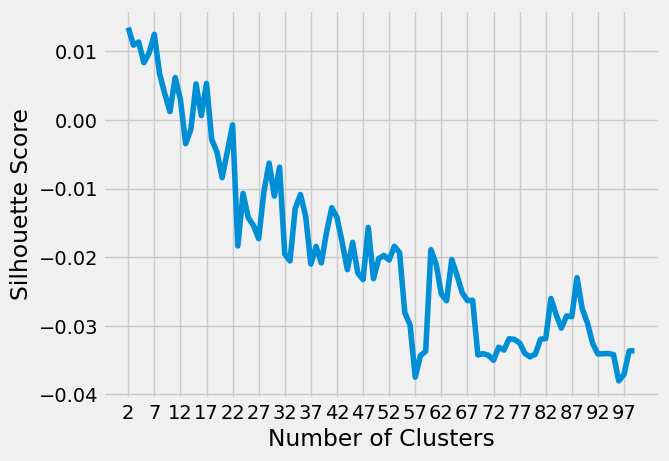

In [48]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 100), silhouette_avg_scores)
plt.xticks(range(2, 100, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [51]:
KneeLocator(range(2,100), inertias, curve='convex', direction='decreasing').elbow

25

Vamos analisar os clusters para n_clusters = 25 e 26

In [80]:
clusterer = KMeans(n_clusters=25, **kmeans_kwargs)
k_means_cluster_labels = clusterer.fit_predict(ratings_matrix_normalized)

In [81]:
movies_reviewed['kmeans_cluster'] = k_means_cluster_labels

In [82]:
cluster_counts = movies_reviewed['kmeans_cluster'].value_counts()
print('Filmes em cada cluster formado: \n', cluster_counts)

Filmes em cada cluster formado: 
 kmeans_cluster
3     568
16    282
23    263
19    215
22    211
0     171
5     154
24    153
1     149
6     138
7     137
12    133
15    130
14    124
11    110
13     99
9      94
20     89
8      85
21     84
17     79
4      70
2      66
10     57
18     45
Name: count, dtype: int64


In [83]:
def plot_silhouette(ratings_matrix_normalized, k_means_cluster_labels, n_clusters):
    # Calcular a média do coeficiente de Silhouette
    silhouette_avg = silhouette_score(ratings_matrix_normalized, k_means_cluster_labels)
    print(f'Para n_clusters = {n_clusters}, a média do coeficiente de Silhouette é: {silhouette_avg}')
    
    # Calcular os coeficientes de Silhouette para cada ponto
    sample_silhouette_values = silhouette_samples(ratings_matrix_normalized, k_means_cluster_labels)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # O subplot para o gráfico de Silhouette
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(ratings_matrix_normalized) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Coeficientes de Silhouette para os pontos do cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[k_means_cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Rotular os gráficos de Silhouette com os números dos clusters no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Atualizar y_lower para o próximo plot
        y_lower = y_upper + 10

    ax1.set_title("O gráfico de Silhouette para os vários clusters.")
    ax1.set_xlabel("Valores do coeficiente de Silhouette")
    ax1.set_ylabel("Rótulo do cluster")

    # Linha vertical para a média do coeficiente de Silhouette de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Limpar os rótulos / ticks do eixo y
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()

Para n_clusters = 25, a média do coeficiente de Silhouette é: -0.01423123176919605


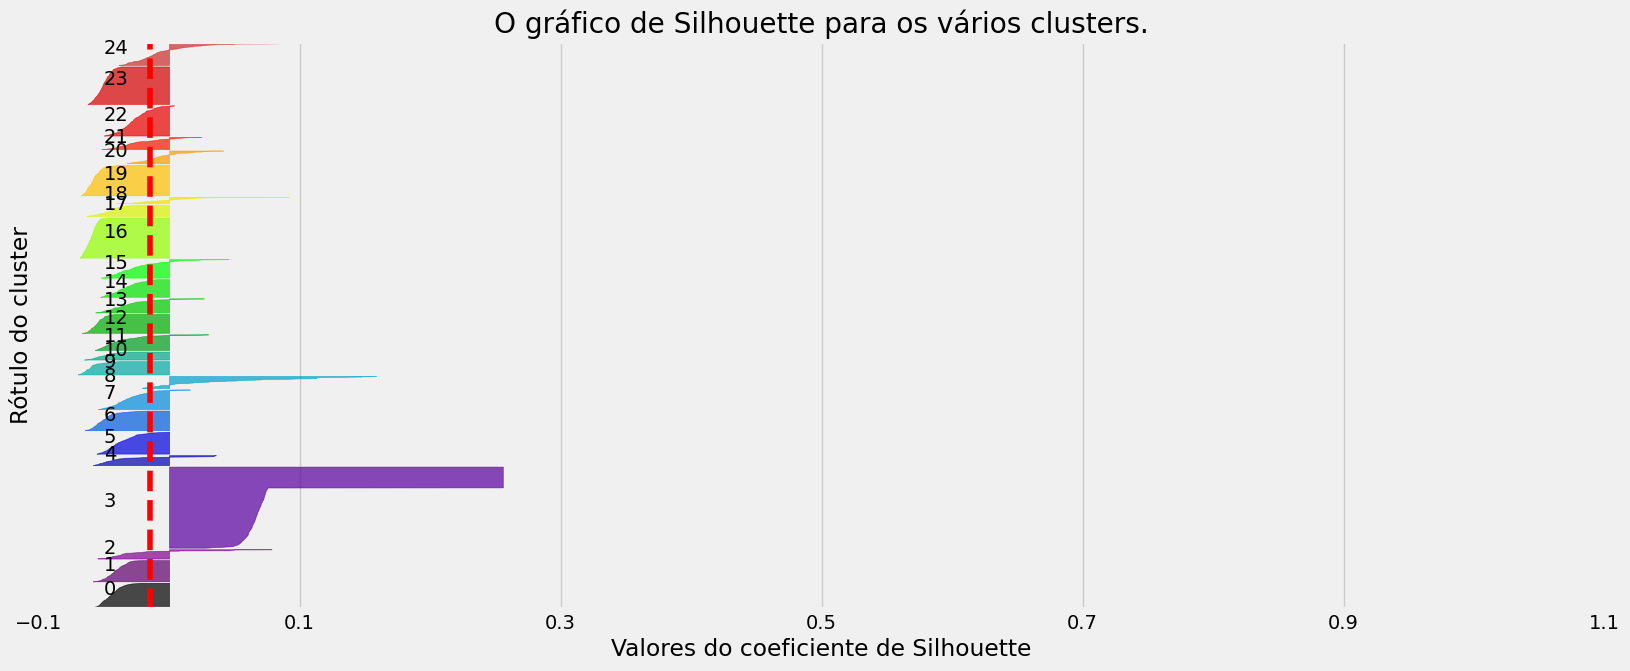

In [84]:
plot_silhouette(ratings_matrix_normalized, k_means_cluster_labels, 25)

In [85]:
clusterer = KMeans(n_clusters=26, **kmeans_kwargs)
k_means_cluster_labels = clusterer.fit_predict(ratings_matrix_normalized)

In [86]:
movies_reviewed['kmeans_cluster'] = k_means_cluster_labels

In [87]:
cluster_counts = movies_reviewed['kmeans_cluster'].value_counts()

print('Filmes em cada cluster formado: \n', cluster_counts)

Filmes em cada cluster formado: 
 kmeans_cluster
4     562
13    380
14    250
23    211
15    210
24    189
16    165
12    157
0     135
20    126
10    123
8     118
5     116
1     113
11    106
18    100
19     96
7      85
17     82
2      74
25     69
22     57
6      55
3      45
9      43
21     39
Name: count, dtype: int64


Para n_clusters = 26, a média do coeficiente de Silhouette é: -0.01537644151089866


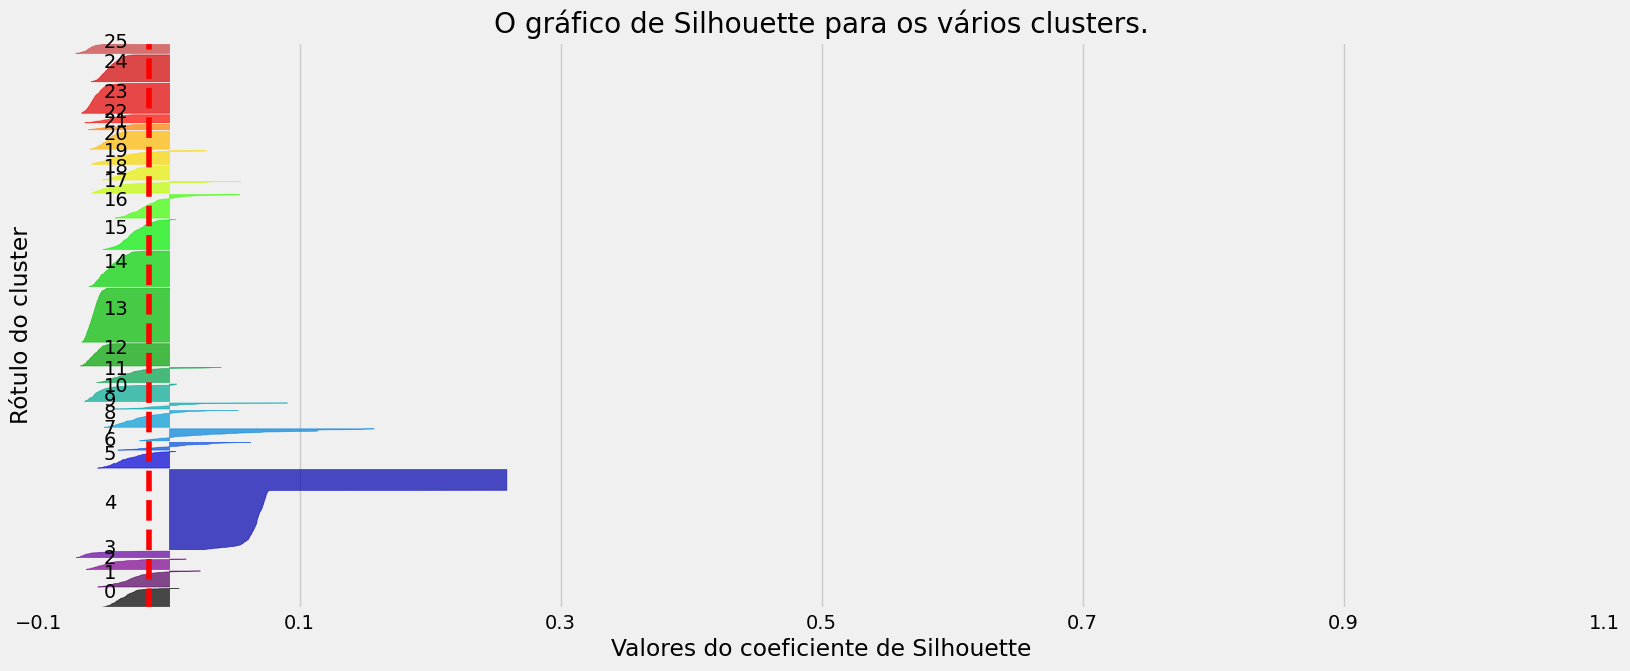

In [88]:
plot_silhouette(ratings_matrix_normalized, k_means_cluster_labels, 26)

Por aparentemente não ter muita diferença, seguiremos com n_clusters = 26

## 6.2. Clustering Hierárquico

Aqui vamos utilizar um número de clusters semelhante ao KMeans

In [89]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=26, metric='precomputed', linkage='complete')
hierarchical__clustering_labels = hierarchical_clustering.fit_predict(square_dist_matrix)

In [91]:
len(hierarchical__clustering_labels)

3706

In [92]:
movies_reviewed['hierarchical_cluster'] = hierarchical__clustering_labels

In [94]:
cluster_counts = movies_reviewed['hierarchical_cluster'].value_counts()
print('Filmes em cada cluster formado: \n', cluster_counts)

Filmes em cada cluster formado: 
 hierarchical_cluster
5     638
2     430
24    318
4     236
1     211
3     192
8     166
10    161
0     160
19    157
6     145
21    119
11     95
9      91
17     80
14     73
7      69
18     67
13     48
23     46
20     41
16     39
15     39
22     38
12     29
25     18
Name: count, dtype: int64


## 6.3. DBscan

In [123]:
dbscan_clusterer = DBSCAN(eps=20, min_samples=2, metric='precomputed')
dbscan_labels = dbscan_clusterer.fit_predict(square_dist_matrix)

In [125]:
movies_reviewed['dbscan_cluster'] = dbscan_labels

In [124]:
np.unique(dbscan_labels, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([3556,  146,    2,    2], dtype=int64))

Não sei bem o que concluir a partir disto

# 7. Análise dos clusters

In [128]:
unique_genres = set()
for genres in movies['genres']:
    for genre in genres:
        unique_genres.add(genre)

In [129]:
unique_genres = set()
for genres in movies['genres']:
    for genre in genres.split(','):
        unique_genres.add(genre.strip())
unique_genres

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

## 7.1 K-Means

In [131]:
cluster_main_gender_kmeans = {}

In [132]:
for cluster in movies_reviewed['kmeans_cluster'].unique():
    cluster_df = movies_reviewed[movies_reviewed['kmeans_cluster'] == cluster]
    
    genre_counts = {genre: 0 for genre in unique_genres}
    
    cluster_total_movies = len(cluster_df)
    for genres in cluster_df['genres'].dropna():
        for genre in genres.split(','):
            if genre in genre_counts:
                genre_counts[genre] += 1
    
    if genre_counts:
        main_gender = max(genre_counts, key=genre_counts.get)
        percentage = (genre_counts[main_gender] / cluster_total_movies) * 100
    else:
        main_gender = None  
    
    cluster_main_gender_kmeans[cluster] = (main_gender, percentage)

In [134]:
cluster_main_gender_kmeans

{5: ("Children's", 94.82758620689656),
 24: ('Comedy', 53.96825396825397),
 14: ('Comedy', 91.60000000000001),
 11: ('Drama', 33.9622641509434),
 13: ('Drama', 65.0),
 15: ('Action', 82.38095238095238),
 18: ('Action', 81.0),
 25: ('Drama', 42.028985507246375),
 17: ('Drama', 47.5609756097561),
 4: ('Drama', 44.83985765124555),
 23: ('Drama', 59.241706161137444),
 9: ('Drama', 83.72093023255815),
 19: ('Romance', 48.95833333333333),
 8: ('Drama', 98.30508474576271),
 22: ('Musical', 47.368421052631575),
 1: ('Horror', 58.4070796460177),
 2: ('Drama', 52.702702702702695),
 10: ('Drama', 70.73170731707317),
 20: ('Action', 35.714285714285715),
 12: ('Drama', 37.57961783439491),
 7: ('Drama', 49.411764705882355),
 3: ('Comedy', 46.666666666666664),
 21: ('Drama', 69.23076923076923),
 0: ('Horror', 89.62962962962962),
 16: ('Drama', 39.39393939393939),
 6: ('Horror', 50.90909090909091)}

É possível ver que foi possível obter clusters bem razoáveis para filmes infantis, de comédia, drama e terror

Vamos definir algumas sagas famosas e ver em que clusters elas foram classificadas

In [142]:
def print_sagas_in_clusters(df, cluster_col):
    rocky_saga_movies = ['Rocky (1976)', 'Rocky II (1979)', 'Rocky III (1982)', 'Rocky IV (1985)', 'Rocky V (1990)']
    karate_kid_saga_movies = ['Karate Kid, The (1984)', 'Karate Kid, Part II, The (1986)', 'Karate Kid III, The (1989)']
    superman_saga_movies  = ['Superman (1978)', 'Superman II (1980)', 'Superman III (1983)', 'Superman IV: The Quest for Peace (1987)']
    batman_saga_movies = ['Batman Forever (1995)', 'Batman (1989)', 'Batman Returns (1992)', 'Batman & Robin (1997)']
    godfather_saga_movies = ['Godfather: Part III, The (1990)', 'Godfather: Part II, The (1974)', 'Godfather, The (1972)']
    starwars_saga_movies = ['Star Wars: Episode I - The Phantom Menace (1999)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode IV - A New Hope (1977)']
    startrek_saga_movies = ['Star Trek: First Contact (1996)', 'Star Trek: The Motion Picture (1979)', 'Star Trek VI: The Undiscovered Country (1991)', 'Star Trek V: The Final Frontier (1989)', 'Star Trek: The Wrath of Khan (1982)', 'Star Trek III: The Search for Spock (1984)', 'Star Trek IV: The Voyage Home (1986)', 'Star Trek: Insurrection (1998)']
    all_saga_movies = {
        "Rocky Movies": rocky_saga_movies,
        "Karate Kid Movies": karate_kid_saga_movies,
        "Superman Movies": superman_saga_movies,
        "Batman Movies": batman_saga_movies,
        "Godfather Movies": godfather_saga_movies,
        "Star Wars Movies": starwars_saga_movies,
        "Star Trek Movies": startrek_saga_movies
    }

    for movie_category, movies in all_saga_movies.items():
        print(f"\n{movie_category}:")
        for movie in movies:
            if movie in df['title'].values:
                cluster_value = df.loc[df['title'] == movie, cluster_col].values[0]
                print(f"{movie}: Cluster {cluster_value}")
            else:
                print(f"{movie}: Not found in DataFrame")

In [143]:
print_sagas_in_clusters(movies_reviewed, 'kmeans_cluster')


Rocky Movies:
Rocky (1976): Cluster 18
Rocky II (1979): Cluster 18
Rocky III (1982): Cluster 18
Rocky IV (1985): Cluster 18
Rocky V (1990): Cluster 15

Karate Kid Movies:
Karate Kid, The (1984): Cluster 24
Karate Kid, Part II, The (1986): Cluster 24
Karate Kid III, The (1989): Cluster 15

Superman Movies:
Superman (1978): Cluster 18
Superman II (1980): Cluster 18
Superman III (1983): Cluster 15
Superman IV: The Quest for Peace (1987): Cluster 15

Batman Movies:
Batman Forever (1995): Cluster 15
Batman (1989): Cluster 18
Batman Returns (1992): Cluster 18
Batman & Robin (1997): Cluster 15

Godfather Movies:
Godfather: Part III, The (1990): Cluster 15
Godfather: Part II, The (1974): Cluster 13
Godfather, The (1972): Cluster 13

Star Wars Movies:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 18
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 18
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 18
Star Wars: Episode IV - A New Hope (1977): Cluster 18

St

Podemos ver que a única franquia que ficou inteiramente em um único cluster foi a franquia de Star Wars

In [144]:
kmeans_avg_composition = 0
for key in cluster_main_gender_kmeans:
    kmeans_avg_composition += cluster_main_gender_kmeans[key][1]
kmeans_avg_composition = kmeans_avg_composition/len(cluster_main_gender_kmeans)
kmeans_avg_composition

60.58233095196809

## 7.2 Clustering Hierárquico

In [146]:
cluster_main_gender_hierarchical = {}

In [148]:
for cluster in movies_reviewed['hierarchical_cluster'].unique():
    cluster_df = movies_reviewed[movies_reviewed['hierarchical_cluster'] == cluster]
    
    genre_counts = {genre: 0 for genre in unique_genres}
    
    cluster_total_movies = len(cluster_df)
    for genres in cluster_df['genres'].dropna():
        for genre in genres.split(','):
            if genre in genre_counts:
                genre_counts[genre] += 1
    
    if genre_counts:
        main_gender = max(genre_counts, key=genre_counts.get)
        percentage = (genre_counts[main_gender] / cluster_total_movies) * 100
    else:
        main_gender = None 
    
    cluster_main_gender_hierarchical[cluster] = (main_gender, percentage)

In [149]:
cluster_main_gender_hierarchical

{1: ('Comedy', 28.436018957345972),
 5: ('Drama', 45.141065830721004),
 19: ('Drama', 43.94904458598726),
 2: ('Comedy', 37.2093023255814),
 6: ('Drama', 44.827586206896555),
 10: ('Comedy', 44.099378881987576),
 17: ('Drama', 45.0),
 21: ('Horror', 50.42016806722689),
 3: ('Drama', 35.9375),
 0: ('Comedy', 38.125),
 8: ('Drama', 31.92771084337349),
 11: ('Drama', 50.526315789473685),
 13: ('Drama', 100.0),
 4: ('Horror', 25.0),
 23: ('Drama', 56.52173913043478),
 24: ('Drama', 50.943396226415096),
 9: ('Drama', 49.45054945054945),
 14: ('Drama', 53.42465753424658),
 18: ('Drama', 61.19402985074627),
 16: ('Drama', 58.97435897435898),
 12: ('Drama', 58.620689655172406),
 7: ('Drama', 42.028985507246375),
 22: ('Drama', 68.42105263157895),
 15: ('Drama', 48.717948717948715),
 25: ('Comedy', 77.77777777777779),
 20: ('Drama', 41.46341463414634)}

In [150]:
hierarquico_avg_composition = 0
for key in cluster_main_gender_hierarchical:
    hierarquico_avg_composition += cluster_main_gender_hierarchical[key][1]
hierarquico_avg_composition = hierarquico_avg_composition/len(cluster_main_gender_hierarchical)
hierarquico_avg_composition

49.543757368431365

Apenas um único cluster ficou bem definido, que foi o cluster que foi composto 100% por filmes de drama, já os demais, não tiveram muita coerência

In [153]:
print_sagas_in_clusters(movies_reviewed, 'hierarchical_cluster')



Rocky Movies:
Rocky (1976): Cluster 5
Rocky II (1979): Cluster 5
Rocky III (1982): Cluster 5
Rocky IV (1985): Cluster 5
Rocky V (1990): Cluster 5

Karate Kid Movies:
Karate Kid, The (1984): Cluster 5
Karate Kid, Part II, The (1986): Cluster 5
Karate Kid III, The (1989): Cluster 5

Superman Movies:
Superman (1978): Cluster 2
Superman II (1980): Cluster 2
Superman III (1983): Cluster 5
Superman IV: The Quest for Peace (1987): Cluster 5

Batman Movies:
Batman Forever (1995): Cluster 2
Batman (1989): Cluster 24
Batman Returns (1992): Cluster 24
Batman & Robin (1997): Cluster 2

Godfather Movies:
Godfather: Part III, The (1990): Cluster 5
Godfather: Part II, The (1974): Cluster 5
Godfather, The (1972): Cluster 5

Star Wars Movies:
Star Wars: Episode I - The Phantom Menace (1999): Cluster 24
Star Wars: Episode VI - Return of the Jedi (1983): Cluster 24
Star Wars: Episode V - The Empire Strikes Back (1980): Cluster 24
Star Wars: Episode IV - A New Hope (1977): Cluster 24

Star Trek Movies:
S

Algumas sagas até fizeram sentido, como por exemplo Rocky e Karate Kid. E várias sagas ficaram inteiramente contidas em um único cluster. Porém, Godfather também fez parte deste mesmo cluster e, além disso, não houve nenhum cluster que contivesse ao menos um filme da saga Star Wars e, simultaneamente, ao menos um filme da saga Star Trek.